In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 200 
import graphviz #to visualize decision trees

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn import tree

# Decision Tree in Scikit-Learn

In [4]:
df = pd.read_csv('data/df_clean_2.csv')

In [5]:
# create a list of the columns
features_response = df.columns.to_list()

# we create a list of items to remove 
to_remove = ['ID', 'SEX', 'EDUCATION_CAT', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
             'graduate school','high school','others','university']

# upadated feature response
features_response = [item for item in features_response if item not in to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [6]:
X_train, X_test, y_train, y_test =  train_test_split(df[features_response[:-1]].values,
                                                     df[features_response[-1:]].values,
                                                     test_size=0.2, random_state=24)

In [9]:
# initialize decision tree class
dt = tree.DecisionTreeClassifier(max_depth=2) # why depth of 2?
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

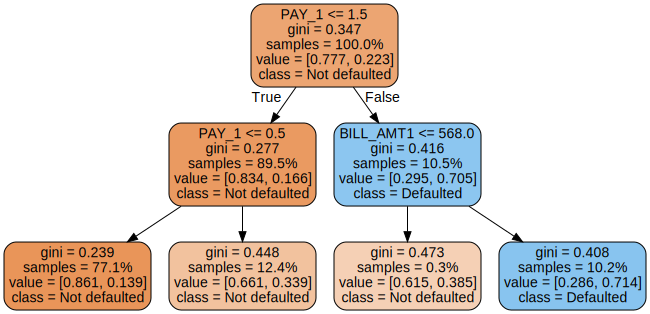

In [10]:
# create graphviz image to visualize decision tree
dot_data = tree.export_graphviz(dt, filled=True, rounded=True,
                                feature_names=features_response[:-1],
                                proportion=True,
                                class_names=['Not defaulted', 'Defaulted'])
# does class name order matter? Yes, class names in ascending order. so O is not defaulted
graph = graphviz.Source(dot_data)
graph

In [11]:
# confirming proportion of training samples where PAY_1 <= 1.5
print(features_response[:-1].index('PAY_1'))
print(X_train.shape)
(X_train[:, 4] <= 1.5).sum() / X_train.shape[0]

4
(21331, 17)


0.8946134733486475

In [12]:
# checking class fractions
# positive training samples
y_train.mean()

0.223102526838873

## Finding optimal hyperparameters

In [14]:
# perform a 4-fold cross-validation. Which will leave 3/4ths of data in each fold
X_train.shape[0] * 0.75

15998.25

Since a tree with n levels and that splits at every node before the last level will have 2n leaf nodes. Therefore, a tree with L leaf nodes has a depth of approximately log2(L). In our case, the theoretical limit will be ~log2(16000) which is approximately 14.

Thus, we will consider a range from 1 to 12 for the max_depth hyperparameter.



In [16]:
# define dictionary with list of values of hyperparameter
depths = [i + 1 for i in range(12)]
params = {'max_depth': depths}
depths

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [17]:
# initalize decision tree model
dt = tree.DecisionTreeClassifier()

In [19]:
# we use ROC AUC mteric and 4-fold cross validation.
# we also calculcate the training score to asses bias-variance trade-off
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc', cv=4,
                  verbose=1, pre_dispatch=None, return_train_score=True)

cv.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [20]:
# get cv results into dataframe
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.017772,0.000641,0.001639,0.000207,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,12,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.033448,0.000872,0.001680,0.000199,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,9,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.047696,0.000305,0.001553,0.000116,3,{'max_depth': 3},0.719980,0.728065,0.743514,0.724267,0.728957,0.008878,6,0.741871,0.737743,0.733329,0.732286,0.736307,0.003810
3,0.063079,0.000917,0.001613,0.000089,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,4,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
4,0.077442,0.000908,0.001667,0.000100,5,{'max_depth': 5},0.742962,0.739792,0.755473,0.738636,0.744216,0.006690,2,0.771849,0.766688,0.763817,0.763489,0.766461,0.003351
5,0.093056,0.002190,0.001756,0.000138,6,{'max_depth': 6},0.744848,0.745673,0.750802,0.740677,0.745500,0.003600,1,0.782202,0.780125,0.775228,0.774750,0.778076,0.003178
6,0.103631,0.000497,0.001714,0.000066,7,{'max_depth': 7},0.741754,0.736972,0.753659,0.743839,0.744056,0.006078,3,0.795379,0.793110,0.788567,0.786550,0.790901,0.003511
7,0.117215,0.001214,0.001732,0.000046,8,{'max_depth': 8},0.728302,0.732910,0.751174,0.728453,0.735210,0.009401,5,0.811734,0.808296,0.803554,0.802368,0.806488,0.003754
8,0.129269,0.000634,0.001829,0.000083,9,{'max_depth': 9},0.715490,0.719534,0.731841,0.729176,0.724010,0.006720,7,0.831215,0.830076,0.821141,0.818536,0.825242,0.005496
9,0.141236,0.000645,0.001834,0.000032,10,{'max_depth': 10},0.707390,0.704682,0.718838,0.711247,0.710539,0.005329,8,0.848877,0.854091,0.841185,0.836530,0.845171,0.006780


## Plotting error-bars for training and testing scores

Text(0, 0.5, 'ROC AUC')

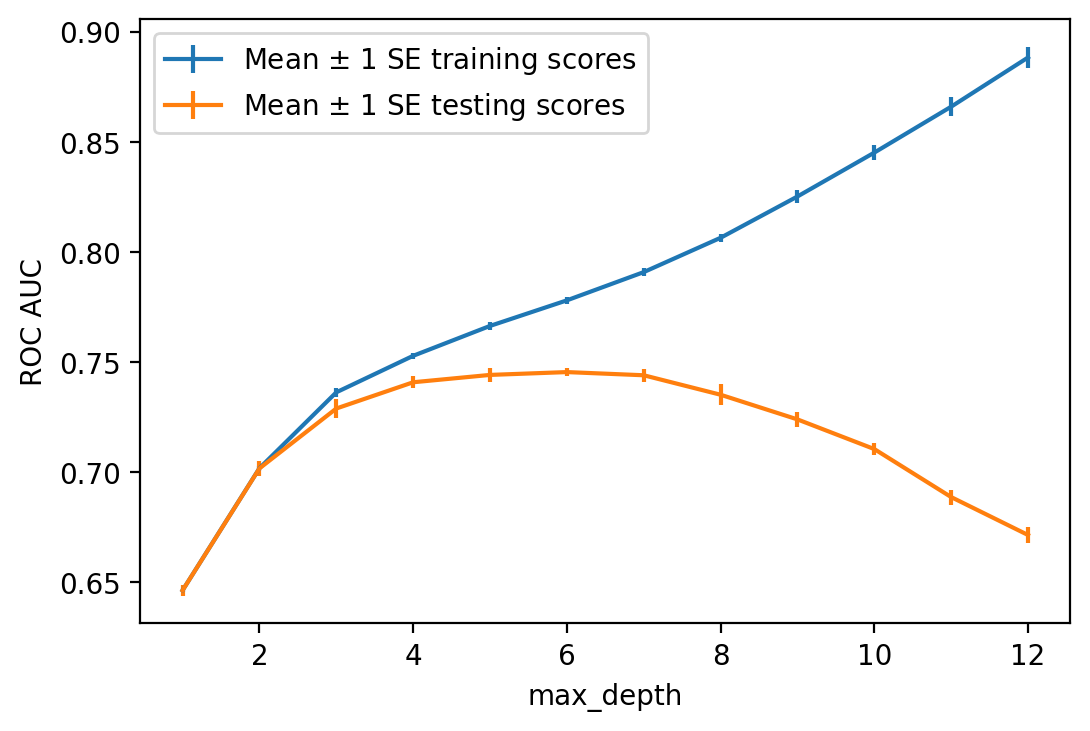

In [21]:
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score']/np.sqrt(4),
            label='Mean $\pm$ 1 SE training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score']/np.sqrt(4),
            label='Mean $\pm$ 1 SE testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

We can see that as the tree grows deeper, the model fits the training data better and better. This is expected as the model becomes more specific to the training data; a model with high-variance.

However, for the training set, there is a point of diminishing returns, past which the scores return lower performance. This is a good example of the bias-variance tradeoff in play. Shallower trees have more bias, but will have better performance on the training data.

We select a max_depth of 6. 

In [22]:
cv_results_df['mean_test_score'].max()

0.7455001615642276

With a decision tree, we make gains in model performance to 0.745

# Random Forests

In [24]:
# instantiate random forrest model
rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=4)

Here, I explore the effect of using different numbers of trees, which I will illustrate with relatively shallow trees
for the sake of shorter runtimes. To find the best model performance, we'd typically try more trees and deeper depths of trees.

In [27]:
rf_params = {'n_estimators': list(range(10, 110, 10))}

In [28]:
cv_rf = GridSearchCV(rf, param_grid=rf_params, 
                     scoring='roc_auc',cv=4, 
                     verbose=1, pre_dispatch=None, 
                     return_train_score=True)
cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataCon

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [29]:
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)
cv_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.090981,0.002107,0.004074,0.000195,10,{'n_estimators': 10},0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,10,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.175427,0.000651,0.006241,0.000042,20,{'n_estimators': 20},0.745612,0.753712,0.777616,0.771737,0.762169,0.012998,9,0.772819,0.771499,0.765944,0.765395,0.768914,0.003284
2,0.260846,0.006970,0.008591,0.000105,30,{'n_estimators': 30},0.747259,0.754154,0.777954,0.771825,0.762798,0.012524,7,0.774655,0.772100,0.765026,0.766697,0.769620,0.003910
3,0.347219,0.010705,0.010571,0.000017,40,{'n_estimators': 40},0.746682,0.754553,0.777709,0.773134,0.763020,0.012813,4,0.774300,0.772642,0.765051,0.765876,0.769467,0.004057
4,0.437391,0.006142,0.013065,0.000156,50,{'n_estimators': 50},0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,1,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
5,0.519954,0.008349,0.015510,0.000731,60,{'n_estimators': 60},0.748437,0.755604,0.779478,0.770978,0.763624,0.012252,2,0.775419,0.773615,0.766133,0.767032,0.770550,0.004031
6,0.622265,0.020560,0.017982,0.000281,70,{'n_estimators': 70},0.747491,0.754465,0.779104,0.771023,0.763021,0.012620,3,0.774420,0.773379,0.765960,0.766174,0.769983,0.003934
7,0.688859,0.003821,0.021191,0.002644,80,{'n_estimators': 80},0.747424,0.754488,0.778753,0.770872,0.762884,0.012502,5,0.774234,0.773257,0.765978,0.766220,0.769922,0.003840
8,0.784068,0.007340,0.022088,0.000207,90,{'n_estimators': 90},0.747097,0.753794,0.778507,0.770426,0.762456,0.012571,8,0.774095,0.772973,0.766022,0.765748,0.769709,0.003846
9,0.861579,0.007509,0.024217,0.000163,100,{'n_estimators': 100},0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,6,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750


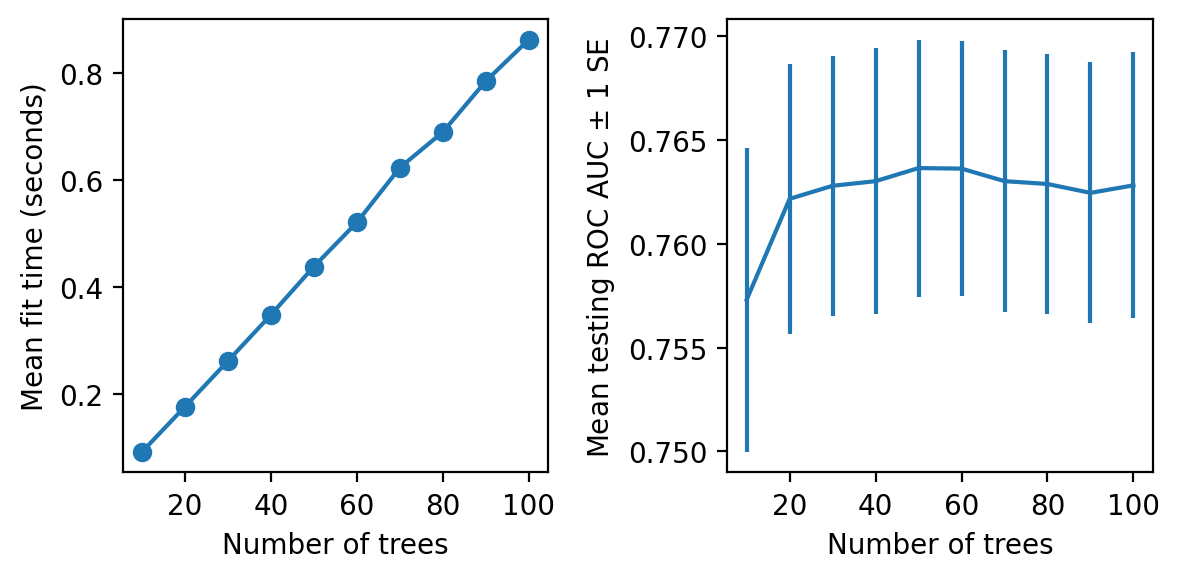

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

axs[0].plot(cv_rf_results_df['param_n_estimators'], cv_rf_results_df['mean_fit_time'], '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_results_df['param_n_estimators'],
                cv_rf_results_df['mean_test_score'],
                yerr=cv_rf_results_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')
plt.tight_layout()

While we haven't made an attempt to tune the random forest hyperparameters to achieve the best model performance we can, this is a promising result and indicates that a random forest will be a valuable addition to our modeling efforts.

However, along with these higher model testing scores, notice that there is also more variability between the folds than what we saw with the decision tree; this variability is visible as larger standard errors in model testing scores across the folds.

We see that even the lowest score from an individual fold is still higher than the average testing score from the decision tree, indicating that it will be better to use a random forest.

## Best hyperparameters and feature importance

In [35]:
cv_rf.best_params_

{'n_estimators': 50}

In [36]:
feat_imp_df = pd.DataFrame({'Importance':cv_rf.best_estimator_.feature_importances_},
                           index=features_response[:-1])
feat_imp_df

# Note that the feature importances comes from the model with the highest
# average testing scores

,Importance
LIMIT_BAL,0.079265
EDUCATION,0.001630
MARRIAGE,0.000170
AGE,0.000459
PAY_1,0.609609
BILL_AMT1,0.008574
BILL_AMT2,0.022422
BILL_AMT3,0.013321
BILL_AMT4,0.013454
BILL_AMT5,0.011264


<AxesSubplot:>

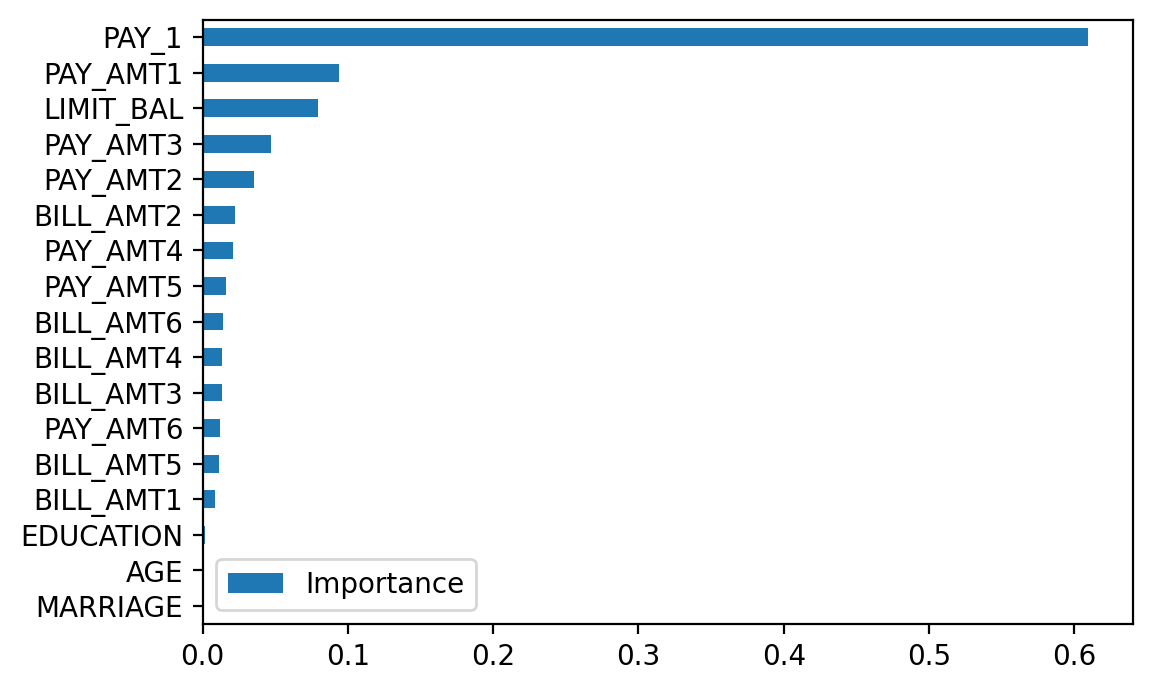

In [37]:
feat_imp_df.sort_values('Importance', ascending=True).plot.barh()

Notice that the top five most important features from the random forest are the same as the top five chosen by an ANOVA F-test in Chapter 3, Details of Logistic Regression and Feature Exploration, although they are in a somewhat different order. This is good confirmation between the different methods.

## Finding Optimal Hyperparameters: n_estimators and max_depth

In [39]:
rf_params_2 = {'n_estimators': [10, 50, 100, 200],
               'max_depth': [3, 6, 9, 12]}

In [40]:
cv_rf = GridSearchCV(rf, param_grid=rf_params_2, scoring='roc_auc',
                     cv=4, verbose=2, pre_dispatch=None, return_train_score=True)

cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=100; total time=   0.9s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=100; total time=   1.0s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=100; total time=   0.9s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=100; total time=   0.9s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=200; total time=   1.8s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=200; total time=   1.8s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=200; total time=   1.8s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=3, n_estimators=200; total time=   1.8s
[CV] END .......................max_depth=6, n_estimators=10; total time=   0.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=6, n_estimators=10; total time=   0.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=10; total time=   0.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.8s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.8s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.8s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.8s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=100; total time=   1.5s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=100; total time=   1.5s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=100; total time=   1.6s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=100; total time=   1.6s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=200; total time=   3.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=200; total time=   3.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=200; total time=   3.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=6, n_estimators=200; total time=   3.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=10; total time=   0.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=10; total time=   0.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=10; total time=   0.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=10; total time=   0.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   1.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   1.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   1.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   1.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=100; total time=   2.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=100; total time=   2.3s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=100; total time=   2.2s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=100; total time=   2.1s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=200; total time=   4.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=200; total time=   4.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=200; total time=   4.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=9, n_estimators=200; total time=   4.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=10; total time=   0.3s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=10; total time=   0.3s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=10; total time=   0.3s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=10; total time=   0.3s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=50; total time=   1.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=50; total time=   1.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=50; total time=   1.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=12, n_estimators=50; total time=   1.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=100; total time=   2.7s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=100; total time=   2.7s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=100; total time=   2.7s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=100; total time=   2.7s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=200; total time=   5.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=200; total time=   5.4s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=200; total time=   5.3s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .....................max_depth=12, n_estimators=200; total time=   5.6s


/home/gregory/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=2)

In [41]:
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)
cv_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.095946,0.003170,0.004417,0.000208,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,15,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.449800,0.007862,0.013297,0.000424,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,12,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
2,0.893538,0.027465,0.025902,0.001788,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,13,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750
3,1.712495,0.005375,0.046507,0.000168,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.747454,0.753057,0.777644,0.771729,0.762471,0.012550,14,0.774453,0.773534,0.766139,0.767404,0.770382,0.003653
4,0.152561,0.001221,0.004766,0.000227,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.752905,0.758904,0.780036,0.774017,0.766466,0.010980,11,0.795911,0.796476,0.793695,0.796446,0.795632,0.001141
5,0.749831,0.003740,0.016402,0.000257,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
6,1.517484,0.017794,0.032358,0.002257,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
7,3.055160,0.039577,0.062066,0.001343,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
8,0.219780,0.005920,0.006182,0.000268,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211
9,1.075966,0.012686,0.021446,0.000285,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672


In [42]:
z = cv_rf_results_df['mean_test_score'].values.reshape((4,4))
z

array([[0.75730766, 0.76365051, 0.76281941, 0.76247114],
       [0.7664656 , 0.77314378, 0.77355231, 0.77359992],
       [0.76716589, 0.77383029, 0.77496884, 0.77619851],
       [0.75722825, 0.77157003, 0.77381473, 0.77549938]])

In [43]:
x, y = np.meshgrid(range(5), range(5)) # mesh has to be provided as numbers

Text(0, 0.5, 'Max depth')

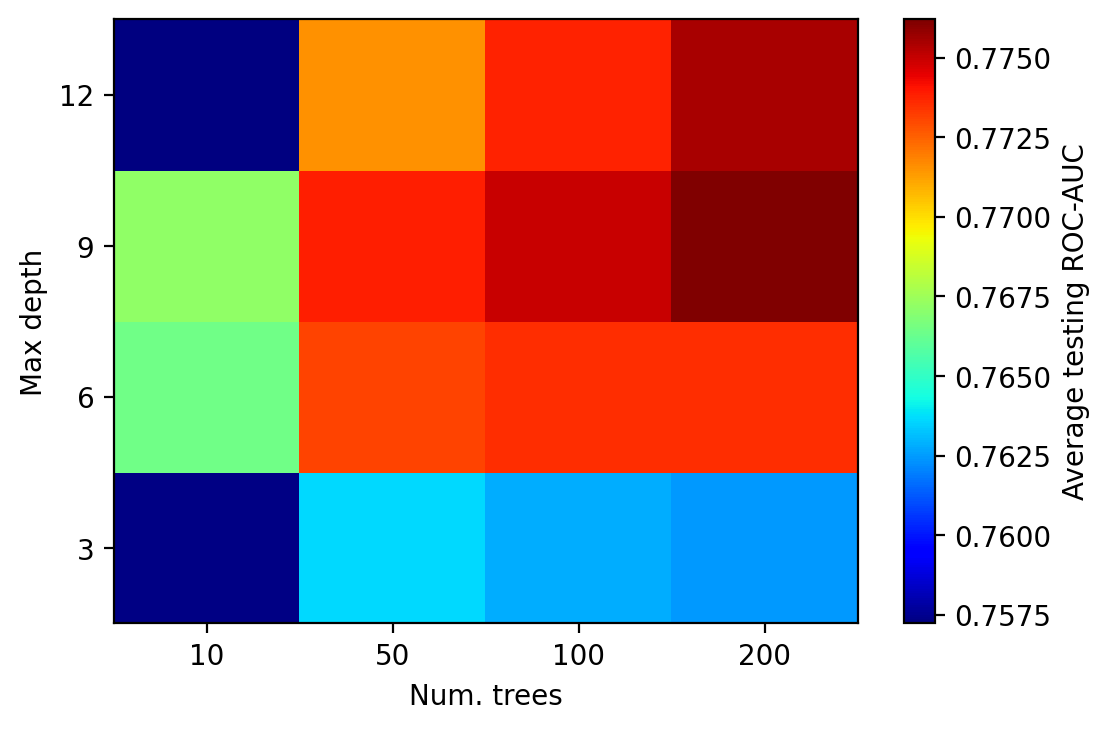

In [44]:
ax = plt.axes()

pcolor = ax.pcolormesh(x, y, z, cmap=plt.cm.jet)
plt.colorbar(pcolor, label='Average testing ROC-AUC')
# ax.set_aspect('equal')
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels([str(tick_label) for tick_label in rf_params_2['n_estimators']])
ax.set_yticklabels([str(tick_label) for tick_label in rf_params_2['max_depth']])

ax.set_xlabel('Num. trees')
ax.set_ylabel('Max depth')

We select max_depth of 9 with 200 trees.